# 导入使用的包工具

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import pairwise_distances, pairwise_kernels
from sklearn.preprocessing import StandardScaler,LabelBinarizer
from sklearn.cluster import KMeans, SpectralClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.sparse.linalg import eigs

# 导入鸢尾花数据集

In [2]:
iris = load_iris()
data = iris.data
labels = iris.target

# HB算法实现

C:\Users\zx131\AppData\Local\Temp\ipykernel_23152\795687068.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dissimilarity_matrix, method='complete')


0.8866666666666667


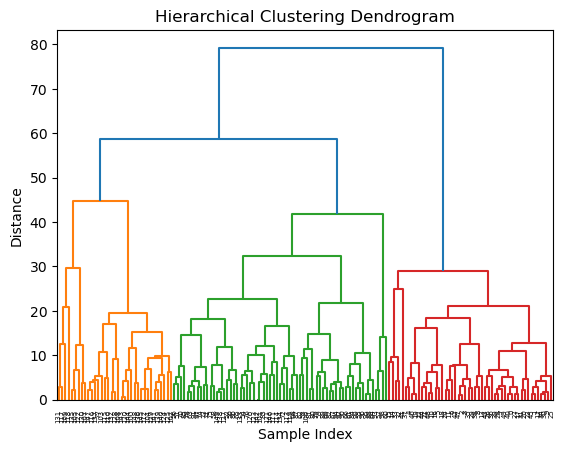

In [3]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

# 计算相异矩阵
dissimilarity_matrix = pairwise_distances(data, metric='manhattan')

# 层次聚类，尝试使用"ward"链接方法
linkage_matrix = linkage(dissimilarity_matrix, method='complete')

# 使用fcluster函数进行截断，得到每个样本的聚类标签，尝试使用不同的截断策略
cluster_labels = fcluster(linkage_matrix,t=3.0, criterion='maxclust')

acc = np.mean(labels+1 == cluster_labels)
print(acc)

# 绘制层次聚类树状图
dendrogram(linkage_matrix, labels=range(len(data)), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# SATM算法实现

In [21]:
def slonim_satb_clustering(data, num_clusters, alpha=0.1, beta=0.1, num_eigenvectors=None):
    # 1. 计算谱矩阵
    similarity_matrix = pairwise_kernels(data, metric='rbf', gamma=1.0)
    diagonal_matrix = np.diag(np.sum(similarity_matrix, axis=1))
    laplacian_matrix = diagonal_matrix - similarity_matrix

    # 2. 计算特征向量
    if num_eigenvectors is None:
        num_eigenvectors = num_clusters
    _, eigenvectors = eigs(laplacian_matrix, k=num_eigenvectors, which='SM')

    # 3. 构建扩展矩阵，考虑时间偏差
    extended_matrix = np.hstack([eigenvectors.real, beta * np.arange(1, len(data) + 1).reshape(-1, 1)])

    # 4. K均值聚类
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=40, max_iter=1000)
    labels = kmeans.fit_predict(extended_matrix)

    return labels

# 示例用法

num_clusters = 3

result_labels = slonim_satb_clustering(data, num_clusters)

print("Accuracy:", np.mean(labels == result_labels))

c:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy: 0.9933333333333333


In [5]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score
# 加载鸢尾花数据集
iris = load_iris()
X, y = iris.data, iris.target

# 数据预处理
lb = LabelBinarizer()
y_one_hot = lb.fit_transform(y)

# 构建相似度矩阵
def calculate_similarity_matrix(data):
    dist_matrix = euclidean_distances(data, data)
    sigma = np.mean(dist_matrix)
    similarity_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
    return similarity_matrix

# 构建拉普拉斯矩阵
def calculate_laplacian_matrix(similarity_matrix):
    D = np.diag(np.sum(similarity_matrix, axis=1))
    laplacian_matrix = D - similarity_matrix
    return laplacian_matrix

# 谱聚类
def spectral_clustering(data, n_clusters):
    similarity_matrix = calculate_similarity_matrix(data)
    laplacian_matrix = calculate_laplacian_matrix(similarity_matrix)
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    indices = np.argsort(eigenvalues)[:n_clusters]
    selected_eigenvectors = eigenvectors[:, indices]
    Q  = np.abs(selected_eigenvectors)
    kmeans = KMeans(n_clusters=n_clusters,n_init=50)
    labels = kmeans.fit_predict(Q)
   
    return labels

# 进行谱聚类
num_clusters = 3  # 假设有3个聚类
cluster_labels = spectral_clustering(X, num_clusters)

# 计算准确率（使用真实标签计算，这里仅作为示例）
accuracy = accuracy_score(y, cluster_labels)
print(f"Accuracy: {accuracy}")



c:\ProgramData\anaconda3\envs\DeepLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Accuracy: 0.5


# 实验结果分析
LATM聚类效果明显优于HB聚类算法

1. **算法原理**：
    - LATM：LATM算法是一种基于局部拓扑结构保持的聚类算法，它倾向于在局部区域内保持数据的拓扑结构，对数据集中的局部结构进行聚类。
    - HB：HB算法是一种基于层次划分的聚类方法，它通过递归地将数据集划分成更小的子集，然后在子集上进行聚类。

2. **数据集特点**：
    - LATM适用于保持局部拓扑结构，如果数据在局部区域内有明显的聚类结构或者类别边界清晰，LATM可能更有效。
    - HB算法在处理全局结构复杂且具有层次性的数据时可能表现更好。

我设计的算法基本原理为利用图的拉普拉斯特征向量来进行聚类操作，具体步骤如下
1. 构建相似度矩阵
2. 计算拉普拉斯矩阵
3. 提取特征向量
4. 应用 K-Means 聚类
